# Figure 6:

##### This notebook reproduces the distance measurement for asteroid 2024 ON using real-time observations from the PROMPT telescope in Chile, corresponding to Figure 6 and Table 1 (column 2) of the manuscript. The procedure begins by importing the real-time astrometric RA data, as listed in Table 2, and fitting Equation 1, since the observations span only a single night of approximately four hours. The resulting distance is then converted to astronomical units and compared against the NASA JPL Horizons reference value for validation.

##### To reproduce Figure 5 (left panel), columns 3 and 8 of the csv file “Figure 6 and Table 1 (2024 ON).csv”, located in the GitHub folder “Figures 5–7, Tables 1–3”, are used. Additionally, the RA and DEC values of the Horizons ephemeris are matched to the nearest corresponding timestamps of the real-time observations.

##### Step 1: Here we import all the packages used throughout the notebook:

In [20]:
# For numerical arrays and dataframes.
import numpy as np
import pandas as pd

# For handling plotting and axis formatting
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# Tools for fitting functions to data
from astropy.modeling import models, fitting
from scipy.optimize import curve_fit

# For file handling and regular expressions
import re
import os

# For custom subplot layouts
from matplotlib.gridspec import GridSpec

# Access to trigonometric functions and constants.
import math

##### Step 2: Reading the entire csv file of asteroid 2024 ON

In [21]:
file_path = 'Figure 6 and Table 1 (2024 ON).csv'
data = pd.read_csv(file_path)
print(data.to_string(index=False))

                       FITS_File           JD  Predicted_RA_deg  Predicted_DEC_deg  Detected  Centroid_X_px  Centroid_Y_px  Detected_RA_deg  Detected_DEC_deg  Uncertainty_px
015760_0000_2024_ON_REDUCED.fits 2.460559e+06        269.228500           5.079583      True     434.722959     305.827367       269.228465          5.079513             0.5
015760_0001_2024_ON_REDUCED.fits 2.460559e+06        269.228482           5.079505      True     434.491359     305.525411       269.228509          5.079453             0.5
015760_0002_2024_ON_REDUCED.fits 2.460559e+06        269.228464           5.079427      True     434.629576     305.928196       269.228469          5.079372             0.5
015760_0003_2024_ON_REDUCED.fits 2.460559e+06        269.228447           5.079355      True     435.014769     306.074333       269.228442          5.079320             0.5
015760_0004_2024_ON_REDUCED.fits 2.460559e+06        269.228429           5.079276      True     435.250559     306.545656       2

##### Step 3: Printing the time and RA data needed for the topocentric parallax analysis. 

In [22]:
# Subtracting the minimum in the time column to make the first observation start at 0
jd_adjusted = data['JD']
jd_binned_median1 = jd_adjusted - jd_adjusted.min()

# Extracting the RA values
ra_deg_adjusted_detected1 = data['Detected_RA_deg']

print(f"{'JD Adjusted':<25}{'RA Adjusted Detected':<25}")
print("=" * 75)

for jd, ra in zip(jd_binned_median1, ra_deg_adjusted_detected1):
    print(f"{jd:<25.10f}{ra:<25.10f}")

JD Adjusted              RA Adjusted Detected     
0.0000000000             269.2284646612           
0.0001504631             269.2285093632           
0.0003009262             269.2284693649           
0.0004398152             269.2284417758           
0.0005902783             269.2284395375           
0.0361458343             269.2256644918           
0.0362962973             269.2256404351           
0.0364467590             269.2256225845           
0.0365856481             269.2256340876           
0.0367361112             269.2256149949           
0.0532986112             269.2245030778           
0.0534490743             269.2244639526           
0.0535995374             269.2244555788           
0.0537384264             269.2244575694           
0.0538888890             269.2244371495           
0.0799421300             269.2228845936           
0.0800925931             269.2229171850           
0.0802314812             269.2228881224           
0.0803819452             269.22

##### Step 4: Remove rows with missing RA data in either the real-time observations or the Horizons data, wherever needed.

In [23]:
# np.isnan(...): returns True for elements where the RA value is NaN (i.e., missing).
# mask: a boolean array that is True for valid RA measurements and False where RA is NaN.
mask = ~np.isnan(ra_deg_adjusted_detected1)

# We apply the same mask to both arrays so that only epochs with valid RA measurements are retained. This ensures that the Julian Date and RA arrays remain aligned and have identical lengths.
jd_binned_median = jd_binned_median1[mask]
ra_deg_adjusted_detected = ra_deg_adjusted_detected1[mask]

print(f"{'jd_binned_median':<25}{'ra_deg_adjusted_detected':<25}")
print("=" * 50)

for jd, ra in zip(jd_binned_median, ra_deg_adjusted_detected):
    print(f"{jd:<25.10f}{ra:<25.10f}")

jd_binned_median         ra_deg_adjusted_detected 
0.0000000000             269.2284646612           
0.0001504631             269.2285093632           
0.0003009262             269.2284693649           
0.0004398152             269.2284417758           
0.0005902783             269.2284395375           
0.0361458343             269.2256644918           
0.0362962973             269.2256404351           
0.0364467590             269.2256225845           
0.0365856481             269.2256340876           
0.0367361112             269.2256149949           
0.0532986112             269.2245030778           
0.0534490743             269.2244639526           
0.0535995374             269.2244555788           
0.0537384264             269.2244575694           
0.0538888890             269.2244371495           
0.0799421300             269.2228845936           
0.0800925931             269.2229171850           
0.0802314812             269.2228881224           
0.0803819452             269.22

##### Step 5: Equation 1 in Maryann et al. 2025

In [24]:
# Equation 1 --> Am * sin(2πx + B) + Cx + D, as defined in the paper.
# We use only the linear form of the model since the observations of 2024 ON span only a single night.
# Sinusoidal term --> Am * sin(2πx + B) represents the effect of Earth's rotation (x = time; Am = amplitude of the signal, also referred to as the parallax amplitude; B = phase shift).
# Linear term --> C * x + D represents the asteroid’s linear motion (C * x corresponds to the asteroid’s constant angular velocity; D is the RA offset).
# fit_function_linear defines the Python implementation of Equation 1.

def fit_function_linear(x, A, B, C, D):
    return A * np.sin(2 * np.pi * x + B) + C * x + D

# Fits the linear model to normalized RA as a function of normalized time.
# curve_fit() from scipy.optimize performs a least-squares fit, determining the best-fit values of Am, B, C, and D that reproduce the RA data, assuming 20 mas noise.
# params_sine:     is a NumPy array containing the best-fit parameter values.
# covariance_sine: is the 4×4 covariance matrix describing the uncertainties and correlations among Am, B, C, and D.

params_sine, covariance_sine = curve_fit(fit_function_linear, jd_binned_median, ra_deg_adjusted_detected)
print(f"\033[1;32m Equation 1: sine +linear terms (Paramters):     {params_sine}\033[0m")

# Uncertainties associated with Equation 1.
# These are required for understanding error propagation.

# np.diag(covariance_sine): extracts the variances of Am, B, C, and D.
# np.sqrt(...):             converts the variances into 1σ standard deviations.

sine_uncertainties = np.sqrt(np.diag(covariance_sine))
print(f"\033[1;32m Equation 1: sine +linear terms (Uncertainities):{sine_uncertainties}\033[0m")

 Equation 1: sine +linear terms (Paramters):     [3.68147363e-02 9.74094964e+01 1.50647554e-01 2.69229230e+02]
 Equation 1: sine +linear terms (Uncertainities):[0.00074081 0.01269633 0.0052693  0.00045942]


##### Step 6: The parallax amplitude and uncertainty from the asteroids linear fit

In [25]:
# We read only the parallax amplitude and its uncertainty, and convert to radians. 
# A closer asteroid  → larger sinusoidal amplitude
# A farther asteroid → smaller sinusoidal amplitude

amplitude_deg = params_sine[0]
amplitude_rad = math.radians(amplitude_deg)
print(f"\033[1;32mamplitude (rad):              {amplitude_rad}\033[0m")

amplitude_uncertainty_deg = sine_uncertainties[0]
amplitude_uncertainty_rad = math.radians(amplitude_uncertainty_deg)
print(f"\033[1;32mamplitude uncertianity (rad): {amplitude_uncertainty_rad}\033[0m")

amplitude (rad):              0.0006425383617026752
amplitude uncertianity (rad): 1.2929487275112225e-05


##### Step 7: Equation 4 in Maryann et al. 2025 (Distance measurement with respect to the center of the Earth)

In [26]:
earth_radius_km = 6371  # in km

# Distance measurement concerning the center of the Earth. 
distance_km = earth_radius_km / amplitude_rad

# Compute distance uncertainty
distance_uncertainty_km = (earth_radius_km/amplitude_rad) * (amplitude_uncertainty_rad/abs(amplitude_rad))

print(f"\033[1;32mEquation 4: Distance_km: {abs(distance_km):.2f} ± {abs(distance_uncertainty_km):.2f}\033[0m")

Equation 4: Distance_km: 9915361.29 ± 199522.00


##### Step 8: Latitude of the Observatory (Correction 1)

##### Note: The PROMPT latitude used in the published manuscript (30.1732° S) differs slightly from the precise latitude reported by the Skynet Robotic Telescope Network linked below (−30.168°). The code released here uses the Skynet value. This difference has a negligible effect on the topocentric parallax calculation and does not affect any results or conclusions in the paper. 

In [27]:
# The observatory taking the observations of asteroid 2024 ON is the PROMPT telescope in Chile. 
# The observatory is in the southern hemisphere of the Earth at a latitude of 30.168° S. 
# We convert the latitude in degrees to radians. 
# The details for the observatory position are taken from the Skynet Robotic Telescope Network website, noted as follows: 
# https://skynet.unc.edu/sites/view?id=2 
# LATITUDE:	-30.168 degrees, LONGITUDE:	-70.805 degrees, ELEVATION:	2286 meters

latitude_deg = 30.168
latitude_rad = math.radians(latitude_deg)
print("Latitude (rad):              ", latitude_rad)

Latitude (rad):               0.5265309287416493


##### Step 9: Declination (DEC) of the observations (Correction 2)

In [28]:
# Since the DEC of the observations is over a single night, the change in DEC is very small, and so, we assume a single DEC value fixed at the first observation.
dec_deg = 5.079513 
dec_rad = math.radians(dec_deg)
print("DEC (rad):                   ", dec_rad)

DEC (rad):                    0.08865422624785474


##### Step 10: Equation 3 in Maryann et al. 2025

In [29]:
# We correct for the distance measurement in step 7 with the latitude and DEC as discussed in steps 8 and 9. 
asteroid_km = (distance_km * math.cos(latitude_rad)) / math.cos(dec_rad)

# Uncertainty
asteroid_uncertainty_km = asteroid_km * (distance_uncertainty_km / distance_km)

print(f"\033[1;32mEquation 3: Asteroid Distance (km):{abs(asteroid_km):.2f} ± {abs(asteroid_uncertainty_km):.2f}\033[0m")

Equation 3: Asteroid Distance (km):8606179.49 ± 173177.97


##### Step 11: Asteroid 2024 ON's measured distance converted to astronomical units. 

In [30]:
km_to_au = 149597870.7 # from km to au 

# distance converted to au 
asteroid_dist_au = asteroid_km / km_to_au

# distance uncertainty converted to au
asteroid_dist_uncertainty_au = asteroid_uncertainty_km / km_to_au

print(f"\033[1;32mAsteroid Distance (au):{abs(asteroid_dist_au):.7f} ± {abs(asteroid_dist_uncertainty_au):.7f}\033[0m")

Asteroid Distance (au):0.0575288 ± 0.0011576


##### Step 12: Extracting Mean Distance from Horizons 

In [31]:
true_distance = 0.057979
print(f"\033[1;32mNASA JPL Horizons True distance (au): {true_distance}\033[0m")

NASA JPL Horizons True distance (au): 0.057979


##### Step 13: Comparing measured asteroid distance with Horizons mean distance

In [32]:
if asteroid_dist_au == 0 or true_distance == 0:
    print("\033[1;31mError: One of the values is zero, cannot compute percentage difference.\033[0m")
else:
    percentage_difference = abs(abs(asteroid_dist_au) - abs(true_distance)) / ((abs(asteroid_dist_au) + abs(true_distance)) / 2) * 100
    print(f"\033[1;32mAsteroid Distance Difference between True and Predicted: {percentage_difference:.6f}%\033[0m")

Asteroid Distance Difference between True and Predicted: 0.779590%


##### Step 14: Plotting the motion of asteroid 2024 ON. 

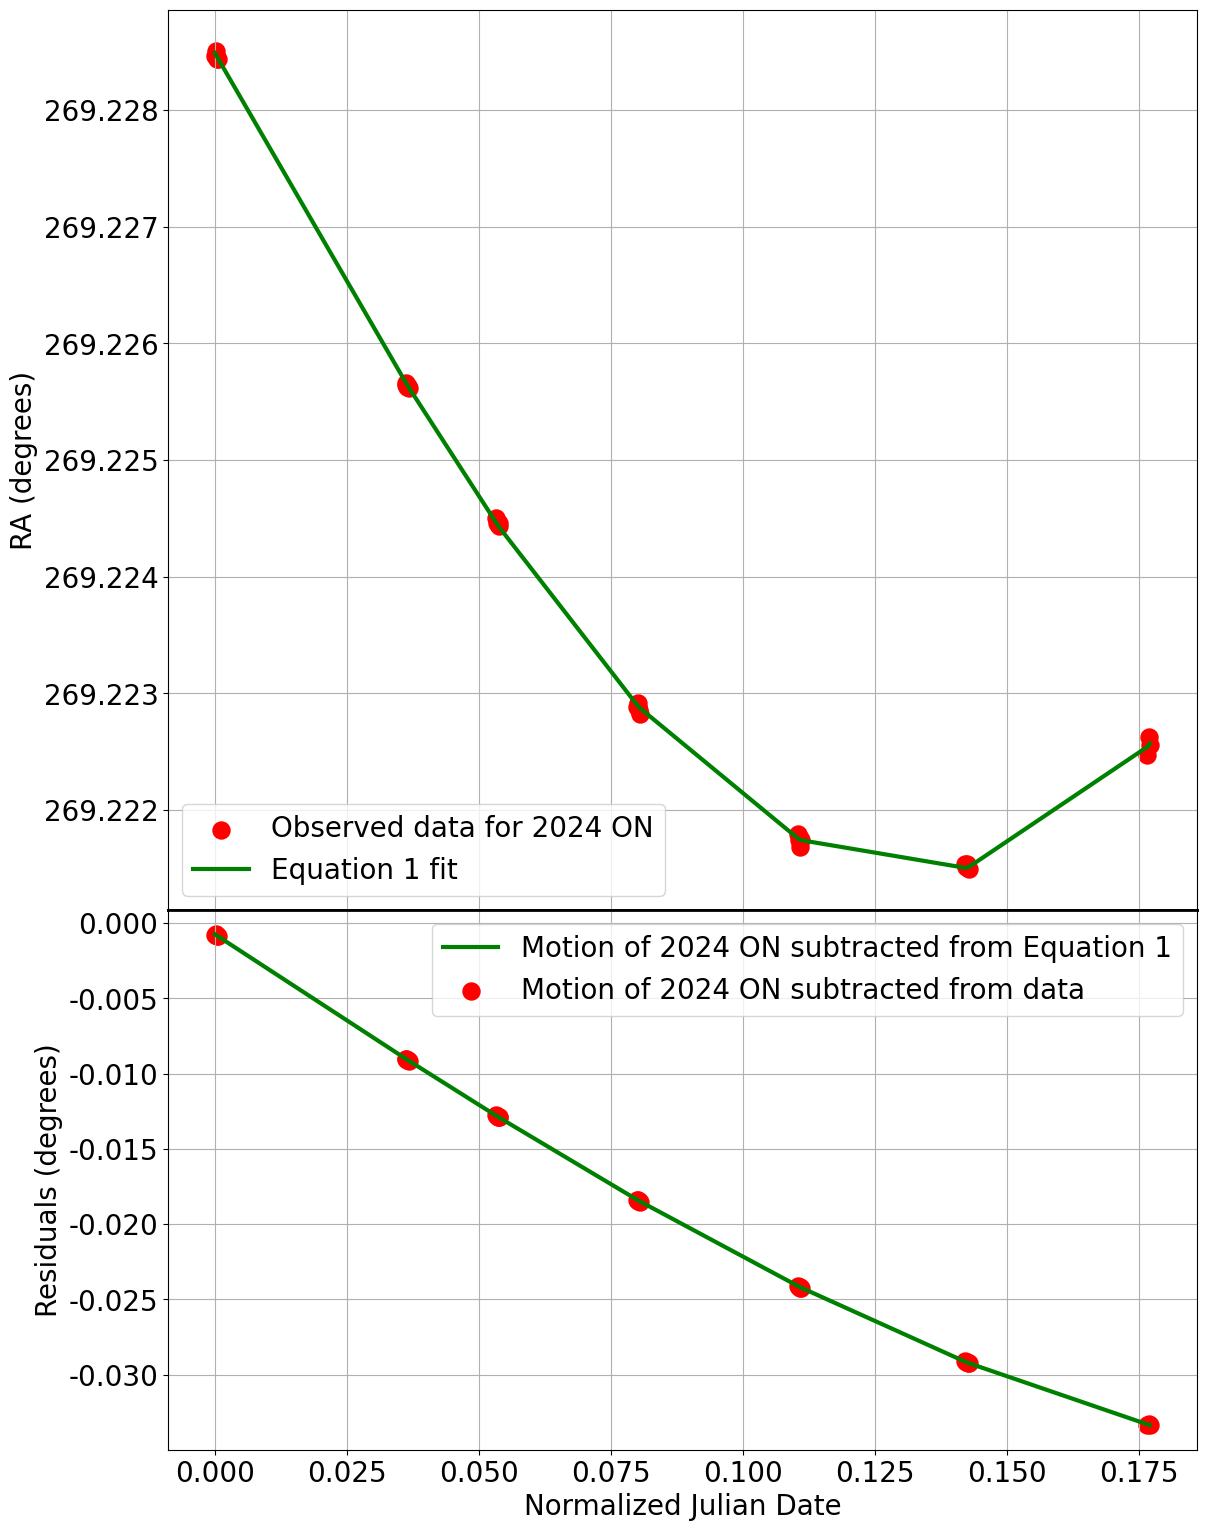

In [33]:
fig = plt.figure(figsize=(12.1, 18))
gs = GridSpec(3, 1, height_ratios=[10, 6, 1], figure=fig)

# Subplot 1: 
ax1 = fig.add_subplot(gs[0, 0])

ax1.scatter(jd_binned_median, ra_deg_adjusted_detected, color='red', label = 'Observed data for 2024 ON', s = 150)
ax1.plot(jd_binned_median, fit_function_linear(jd_binned_median, *params_sine), color='green', label = 'Equation 1 fit', linewidth = 3)

ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.set_ylabel("RA (degrees)", fontsize=20)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax1.set_xticklabels([])
ax1.legend(fontsize=20, loc='lower left')
ax1.grid()

# Subplot 2: 
ax2 = fig.add_subplot(gs[1, 0])

ax2.plot(jd_binned_median, 
         fit_function_linear(jd_binned_median, *params_sine) - (params_sine[2]*jd_binned_median + params_sine[3]), 
         color = 'green', label = 'Motion of 2024 ON subtracted from Equation 1', linewidth = 3)
ax2.scatter(jd_binned_median, ra_deg_adjusted_detected - (params_sine[2]*jd_binned_median + params_sine[3]), 
            color = 'red', label = 'Motion of 2024 ON subtracted from data', s = 150)

ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_xlabel("Normalized Julian Date", fontsize=20)
ax2.set_ylabel("Residuals (degrees)", fontsize=20) 
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.legend(fontsize=20, loc='upper right')
ax2.grid()

plt.subplots_adjust(hspace=0)
plt.gcf().axes[0].spines['bottom'].set_linewidth(2)
plt.gcf().axes[1].spines['top'].set_linewidth(2)

plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.1, hspace=0)
plt.savefig("Figure 6.png", format="png", dpi=300, bbox_inches="tight", facecolor='white')

plt.show()

##### Step 15: Retesting the results as per the exact equations seen in 3 and 4 in the manuscript. 

In [34]:
Dec      = dec_rad
latitude = latitude_rad
Am       = amplitude_rad
Am_sigma = amplitude_uncertainty_rad

# Uncertainties in the final distance measurement is error propogated through a standard first-order Gaussian.

# ---------- Eq. 3: --------------------------------
# The Projected Parallax amplitude and uncertainty
# If Ap is large, the distance is well-constained and the object is closer to the observer, and vice versa

Ap               = (math.cos(Dec)/math.cos(latitude))*Am
Ap_uncertainties = (math.cos(Dec)/math.cos(latitude))*Am_sigma
print(Ap)
print(Ap_uncertainties)
print(f"\033[1;32mAp: {abs(Ap):.6f} ± {abs(Ap_uncertainties):.6f}\033[0m")

# ---------- Eq. 4: --------------------------------
# The asteroids distance is inverse proportional to the parallax amplitude
Asteroid_Distance_km               = earth_radius_km                     /Ap

# and the uncertainty is   ==>   σ_D = |∂D/∂Ap| * σ_Ap   ==>    σ_D = R_earth * σ_Ap / Ap^2 
Asteroid_Distance_km_uncertainties = earth_radius_km * Ap_uncertainties / (Ap**2) 

print(Asteroid_Distance_km)
print(Asteroid_Distance_km_uncertainties)
print(f"\033[1;32mAsteroid Distance (km): {abs(Asteroid_Distance_km):.6f} ± {abs(Asteroid_Distance_km_uncertainties):.6f}\033[0m")

# ---------- Distance (au) ------------------------
Asteroid_Distance_au               = Asteroid_Distance_km              /km_to_au
Asteroid_Distance_au_uncertainties = Asteroid_Distance_km_uncertainties/km_to_au
print(Asteroid_Distance_au)
print(Asteroid_Distance_au_uncertainties)
print(f"\033[1;32mAsteroid Distance (km): {abs(Asteroid_Distance_au):.6f} ± {abs(Asteroid_Distance_au_uncertainties):.6f}\033[0m")

# ---------- % difference -------------------------
if asteroid_dist_au == 0 or true_distance == 0:
    print("\033[1;31mError: One of the values is zero, cannot compute percentage difference.\033[0m")
else:
    percentage_difference = abs(abs(Asteroid_Distance_au) - abs(true_distance)) / ((abs(Asteroid_Distance_au) + abs(true_distance)) / 2) * 100
    print(f"\033[1;32mHorizons versus Measured: {percentage_difference:.2f}%\033[0m")

0.0007402820270647954
1.4896335564408847e-05
Ap: 0.000740 ± 0.000015
8606179.492511654
173177.96861325973
Asteroid Distance (km): 8606179.492512 ± 173177.968613
0.05752875660757419
0.001157623218852805
Asteroid Distance (km): 0.057529 ± 0.001158
Horizons versus Measured: 0.78%


##### FINAL SUMMARY: Topocentric Parallax distance measurement for Asteroid 2024 ON

In [35]:
# 1. Fit parameters from Equation 1
print("=== Fit Parameters from Equation 1 ===")
parameter_names = ["Am (deg)", "B", "C", "D"]
for name, value, error in zip(parameter_names, params_sine, sine_uncertainties):
    print(f"{name:<10}: {value:.6e} ± {error:.6e}")

# 2. Parallax amplitude in radians
print("\n=== Parallax Amplitude ===")
print(f"Am (rad): {amplitude_rad:.6e} ± {amplitude_uncertainty_rad:.6e}")

# 3. Distance results
print("\n=== Distance to Asteroid 2024 ON ===")
print(f"Distance:    {abs(asteroid_km):.2f} km   ({abs(asteroid_dist_au):.6f} au)")
print(f"Uncertainty: ± {abs(asteroid_uncertainty_km):.2f} km  (± {abs(asteroid_dist_uncertainty_au):.6f} au)")

# 4. Percentage Difference
print("\n=== Difference comparism with Horizons mean distance ===")
print(f"Percentage: {abs(percentage_difference):.2f} %")


# 4. Summary Text.
summary_text = """ 
Summary:
--------
We input data of asteroid 2024 ON from NASA JPL Horizons System from September 5-6, 2024, 
totaling 7 observations (five exposures per observation, totalling 35 exposures) as seen in Figures 5 and 6. 
We fit Equation 1 in the manuscript, which connects the Earth's rotation with the linear motion of the asteroid to 
the RA time series of observations within a single night. 

The best-fit sinusoidal amplitude (Am) and its 1σ uncertainty were converted 
to radians and used in Equations 3 and 4 of the manuscript to compute the 
distance to asteroid 2024 ON. The resulting distance and uncertainty are consistent 
with expectations for an object at this geometry and validate that the topocentric parallax 
method is implemented correctly. This confirms that the entire analysis pipeline is 
functioning as described in the manuscript.
"""
print("\n" + summary_text)


=== Fit Parameters from Equation 1 ===
Am (deg)  : 3.681474e-02 ± 7.408051e-04
B         : 9.740950e+01 ± 1.269633e-02
C         : 1.506476e-01 ± 5.269298e-03
D         : 2.692292e+02 ± 4.594212e-04

=== Parallax Amplitude ===
Am (rad): 6.425384e-04 ± 1.292949e-05

=== Distance to Asteroid 2024 ON ===
Distance:    8606179.49 km   (0.057529 au)
Uncertainty: ± 173177.97 km  (± 0.001158 au)

=== Difference comparism with Horizons mean distance ===
Percentage: 0.78 %

 
Summary:
--------
We input data of asteroid 2024 ON from NASA JPL Horizons System from September 5-6, 2024, 
totaling 7 observations (five exposures per observation, totalling 35 exposures) as seen in Figures 5 and 6. 
We fit Equation 1 in the manuscript, which connects the Earth's rotation with the linear motion of the asteroid to 
the RA time series of observations within a single night. 

The best-fit sinusoidal amplitude (Am) and its 1σ uncertainty were converted 
to radians and used in Equations 3 and 4 of the manuscri